In [1]:
import geojson
from tqdm import tqdm
import rasterio.features
import numpy as np
from shapely.geometry import MultiPolygon
import shapely
import matplotlib.pyplot as plt

In [2]:
%%time
path_to_file = './naturtyper_layer.geojson'

with open(path_to_file, 'r') as f:
    gj = geojson.load(f)
print(len(gj['features']), gj.keys())

312325 dict_keys(['type', 'name', 'crs', 'features'])
CPU times: user 1min, sys: 2.81 s, total: 1min 3s
Wall time: 1min 3s


In [3]:
gj_features = []
for feature in tqdm(gj['features']):
    if feature['properties']['Natyp_kode'] == 6: # Code for lakes is 6
        gj_features.append(feature)
print(len(gj_features))
gj_features[0]

100%|██████████████████████████████████████████████████████████████████████| 312325/312325 [00:00<00:00, 1100630.64it/s]

152920


{"geometry": {"coordinates": [[[[501332.248, 6224773.935], [501334.244, 6224779.934], [501334.244, 6224784.933], [501333.246, 6224790.932], [501327.243, 6224789.932], [501317.249, 6224783.933], [501316.243, 6224780.934], [501319.244, 6224774.935], [501324.25, 6224771.936], [501329.247, 6224770.936], [501332.248, 6224773.935]]]], "type": "MultiPolygon"}, "properties": {"Aendr_kode": 0, "Aendrbegr": "Ikke udfyldt", "Besig_dato": null, "Bruger_id": "00000000-0000-0000-0000-000000000000", "CVR_kode": 29189919, "CVR_navn": "Herning kommune", "Gl_sys_ref": null, "Journalnr": null, "Link": null, "Natyp_kode": 6, "Natyp_navn": "Sø", "Objekt_id": "0460cd7c-5353-11e2-af2b-00155d01e765", "Off_kode": 1, "Offentlig": "Synlig for alle", "Oprettet": "2006-12-31T01:00:00", "Oprindelse": "Ikke udfyldt", "Oprindkode": 0, "Sagsbeh": null, "Shape_area": 252.94599999301087, "Shape_length": 0.0, "Status": "Gældende / Vedtaget", "Statuskode": 3, "Systid_fra": "2006-12-31T01:00:00", "Systid_til": null, "Temak

0it [00:00, ?it/s]

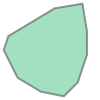

mask shape: (18, 20)


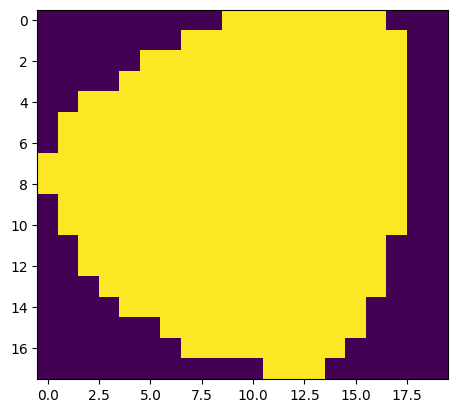

152920it [02:29, 1019.73it/s]

Failed to convert 3665 annotations


In [4]:
dataset = []
failed = 0

# Loop over the annotations
for i, feature in tqdm(enumerate(gj_features)):
    geometry = feature['geometry']
    coords = geometry['coordinates']
    coords_np = np.array(coords[0][0])
    
    try: 
        poly = MultiPolygon(coords)
        min_x, min_y, max_x, max_y = poly.bounds # min x, min y, max x, max y
        x, y = max_x - min_x, max_y - min_y # get width and height

        # Re-center coordinates at (0,0)
        poly = shapely.transform(poly, lambda c: np.round(c - [min_x, min_y]))
        mask = rasterio.features.rasterize([poly], out_shape=(round(x), round(y)))
        mask = np.flip(mask, 0)
    
        # Store in dictionary format for easy access
        data = {'geometry': geometry, 'coordinates': coords[0][0], 'mask': mask.tolist()}
        dataset.append(data)
        
        if i == 0:
            display(poly)
            print('mask shape:', mask.shape)
            plt.imshow(mask)
            plt.show()
            
    except: # Skip any polygons which can't be parsed
        failed += 1
        continue
print(f'Failed to convert {failed} annotations')

In [5]:
import json
with open('denmark_annotations.json', 'w') as f:
    json.dump(dataset, f)